# Convolutional neural networks (CNN) - image classification (part 2)

In this example, we will create a classifier that will classify cats and dogs. It will be shown how we can artificially increase the set of available data using `tf.keras.preprocessing.image.ImageDataGenerator` functionality offered by keras. We will also show the dropout regularization.


## Loading packages

In [10]:
import tensorflow as tf

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Loading data

We will use the <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs Cats</a> dataset from the Kaggle platform. 

Instead of using `tf.keras.utils.get_file`, you can also download the file manually,
place it somewhere on the disk, and update the paths to point to it.

In [12]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

The dataset has the following structure:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

In [13]:
PATH

'/root/.keras/datasets/cats_and_dogs_filtered'

We define the necessary paths to the training and validation datasets, and classes within them.

In [14]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [15]:
train_cats_dir = os.path.join(train_dir, 'cats') 
train_cats_dir = os.path.join(train_dir, 'cats') 
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### Understanding the data

Let's look at basic information about the dataset such as number of instances, number of instances per class, number of classes, how images look, image resolution etc.

In [16]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [17]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


The use of constants in the code should be avoided, so we can define
variables that we will use in the future.

In [18]:
batch_size = 128
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

## Preparing the data

In order to pass images to the network, it is necessary to load them and transform them into tensors.

To facilitate this process, we can use the `ImageDataGenerator` class offered by` tf.keras`. It offers the functionality of reading images from disk and applying defined preprocessing steps that result in a tensor that can be passed to the network.

The next part constructs `ImageDataGenerator` generators for our data set. We define `rescale=1./255` whose generator will multiply each pixel of the image by the value $\frac{1}{255}$.

In [19]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

The `flow_from_directory` function loads images from disk, applies scaling, and scales images to the required size (user-defined). The result of the function is an iterator that we can use to get `batch_size` images over each iterator call.

In [20]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [21]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


In [22]:
train_data_gen

### Visualization of images

Let us now visualize some of the images.

In [23]:
sample_training_images, sample_training_labels = next(train_data_gen)

In [24]:
np.unique(sample_training_labels)

array([0., 1.], dtype=float32)

The function `next` (inside of python standard library) returns a subset (batch) from the data set. The return value is in the form `(x_train, y_train)`.

In [25]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

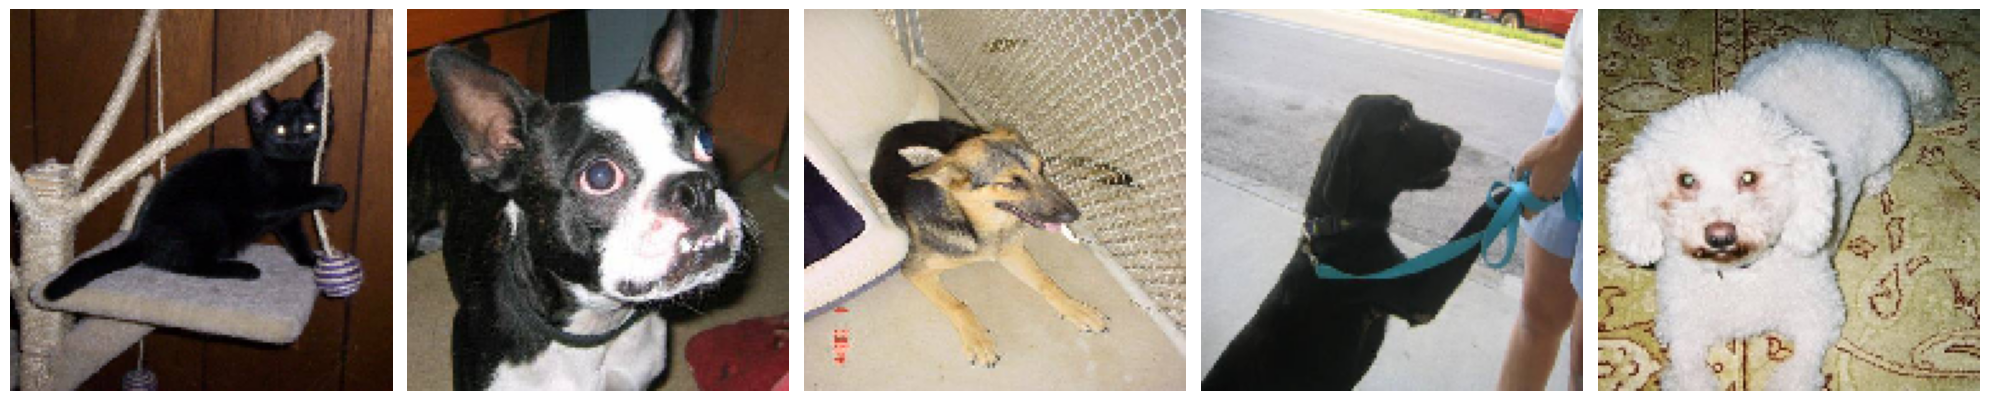

In [26]:
plotImages(sample_training_images[:5])

## Defining the model

Similar to the previous example, we will make several layers consisting of convolution-pooling pairs. After that, we will add a `Flatten` layer to transfer everything to a vector that will be forwarded to the binary classifier.

In fact, instead of 1 neuron, in the end we can use two (as in previous examples with more classes), but there is no need for that. In practice, a single neuron is often used and its activation is observed. We will choose a sigmoid activation function because it resembles a probability function.

In [27]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

2022-12-23 10:59:20.392497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-23 10:59:20.395712: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-23 10:59:20.397115: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-23 10:59:20.397157: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-23 10:59:20.397753: W tensorf

### Compiling the model

For this tutorial, choose the *ADAM* optimizer and *binary cross entropy* loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

### Model summary

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

### Training the model

Since our data is not loaded into working memory as in the previous example, but we use a generator that loads it if necessary, we will use the `fit_generator` function, which expects to be passed a generator that will be able to access the necessary data when training the network.

In [30]:
print(f"total_train: {total_train}")
print(f"total_val: {total_val}")
print(f"batch_size: {batch_size}")
print(f"steps_per_epoch: {total_train // batch_size}")

total_train: 2000
total_val: 1000
batch_size: 128
steps_per_epoch: 15


In [31]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/20
15/15 [==============================] - 31s 2s/step - loss: 0.8162 - accuracy: 0.5155 - val_loss: 0.6918 - val_accuracy: 0.5045
Epoch 2/20
15/15 [==============================] - 26s 2s/step - loss: 0.6890 - accuracy: 0.5032 - val_loss: 0.6845 - val_accuracy: 0.4933
Epoch 3/20
15/15 [==============================] - 24s 2s/step - loss: 0.6703 - accuracy: 0.5929 - val_loss: 0.6403 - val_accuracy: 0.6060
Epoch 4/20
15/15 [==============================] - 25s 2s/step - loss: 0.6287 - accuracy: 0.6533 - val_loss: 0.6076 - val_accuracy: 0.6596
Epoch 5/20
15/15 [==============================] - 25s 2s/step - loss: 0.5855 - accuracy: 0.6806 - val_loss: 0.5927 - val_accuracy: 0.6942
Epoch 6/20
15/15 [==============================] - 26s 2s/step - loss: 0.5535 - accuracy: 0.7174 - val_loss: 0.5942 - val_accuracy: 0.6931
Epoch 7/20
15/15 [==============================] - 26s 2s/step - loss: 0.5097 - accuracy: 0.7569 - val_loss: 0.6384 - val_accuracy: 0.6719
Epoch 8/20
15/15 [==

### Summary of the network training

Now visualize the results after training the network.

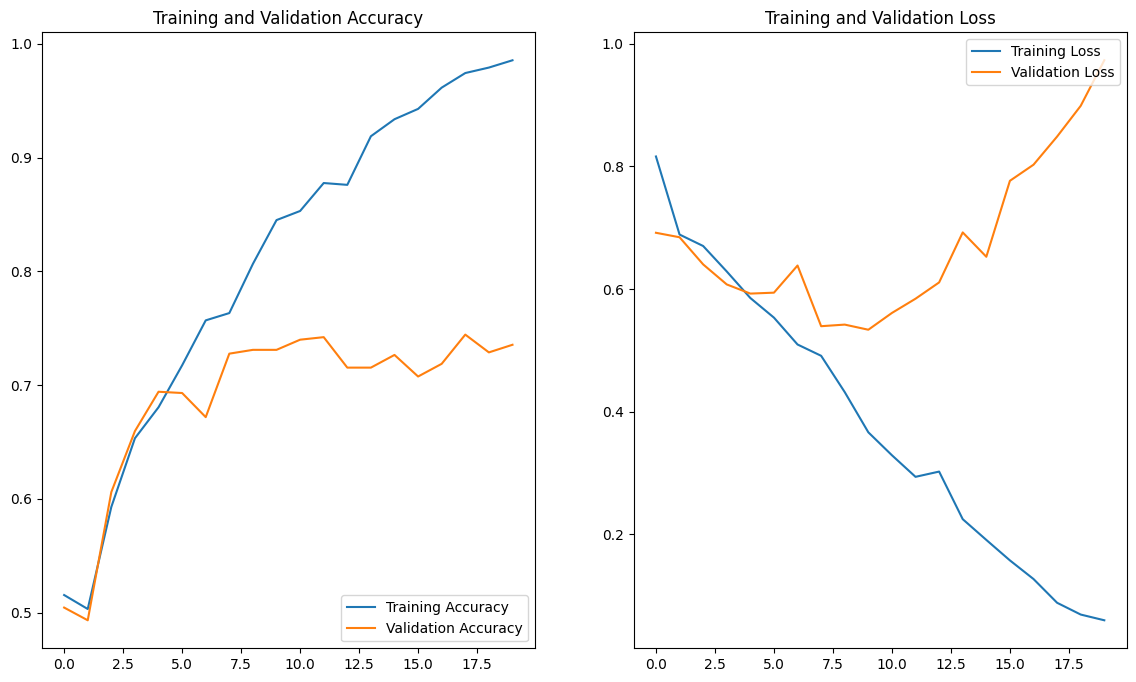

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can notice that the error at the validation set started to grow after about 10 epochs, as well as that the accuracy starts to deviate drastically from the training set. This is a clear sign that there is overfitting. This is to be expected given the complexity of the model we use and the number of instances in the data set available to us.

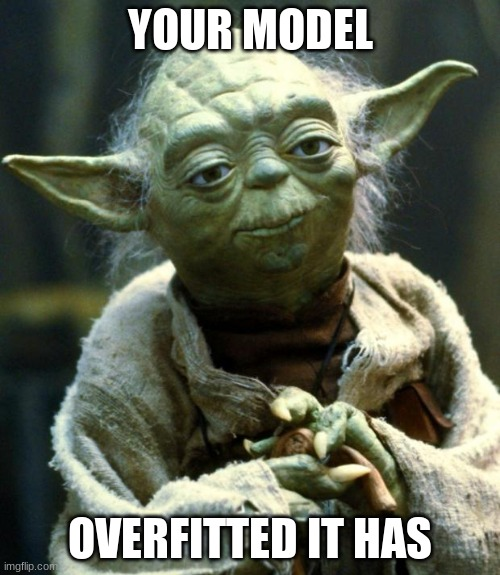

## Data augmentation

We can alleviate the problem of small amounts of data by being able to generate more data based on existing ones using some defined transformations.

`ImageDataGenerator` provides support for this with a fairly simple interface to use.

### Augmentation and visualization of data

Before we define the transformations and let the model train, let's take a closer look at how `ImageDataGenerator` works.

For example, let’s add a horizontal flip.

### Horizontal flip

In [33]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [34]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


We will take one picture from the set and repeat it 5 times to notice
how the transformation we have defined is maintained.

In [35]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

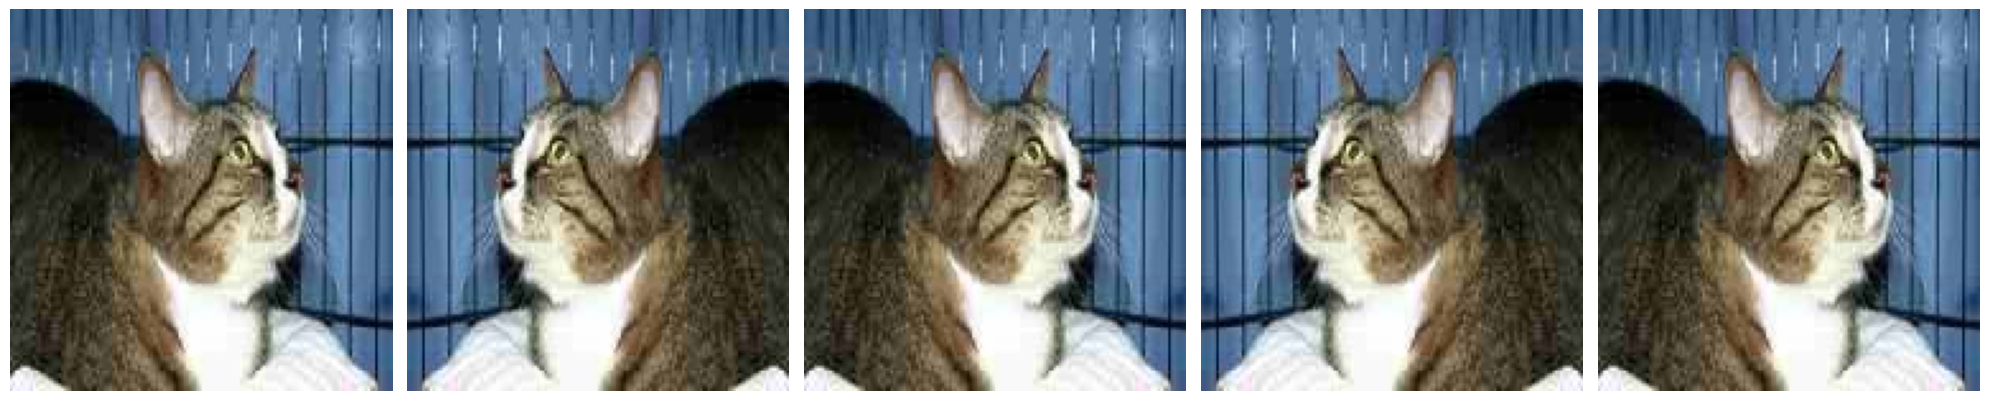

In [36]:
plotImages(augmented_images)

### Rotation of the images

We can add random image rotation in the interval $[-45, 45]$.

In [37]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [38]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


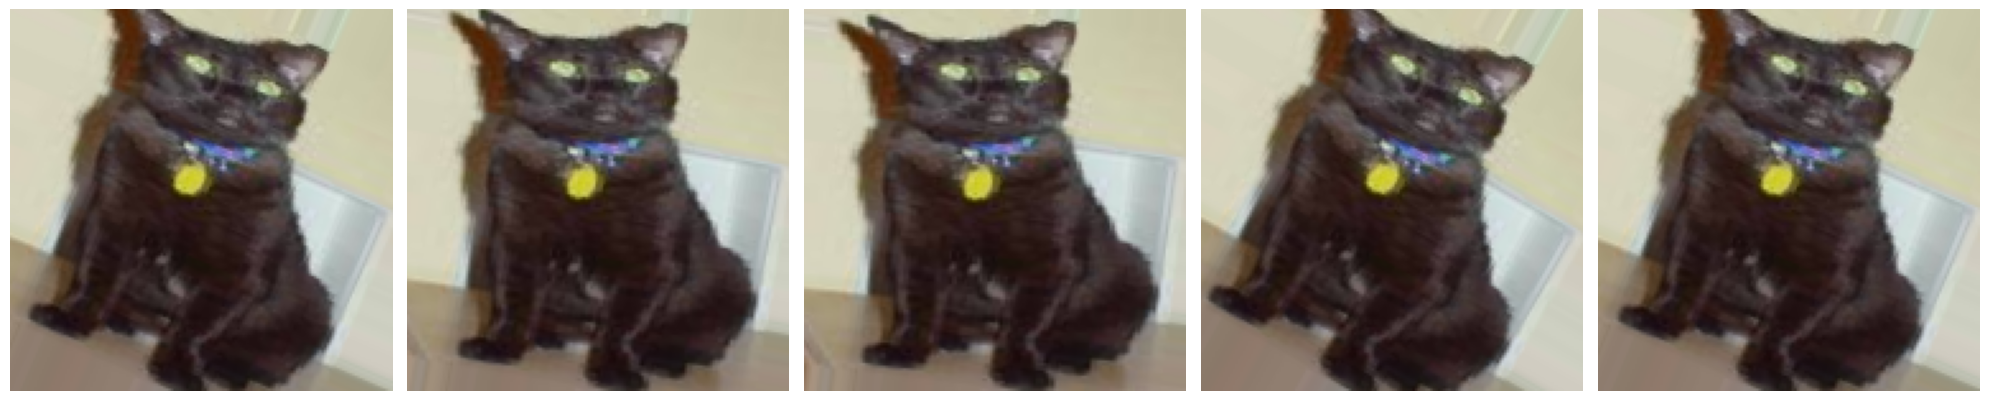

In [39]:
plotImages(augmented_images)

### Zooming the image

A transformation that adds zoom over the image can also be applied.

In [40]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) 

In [41]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


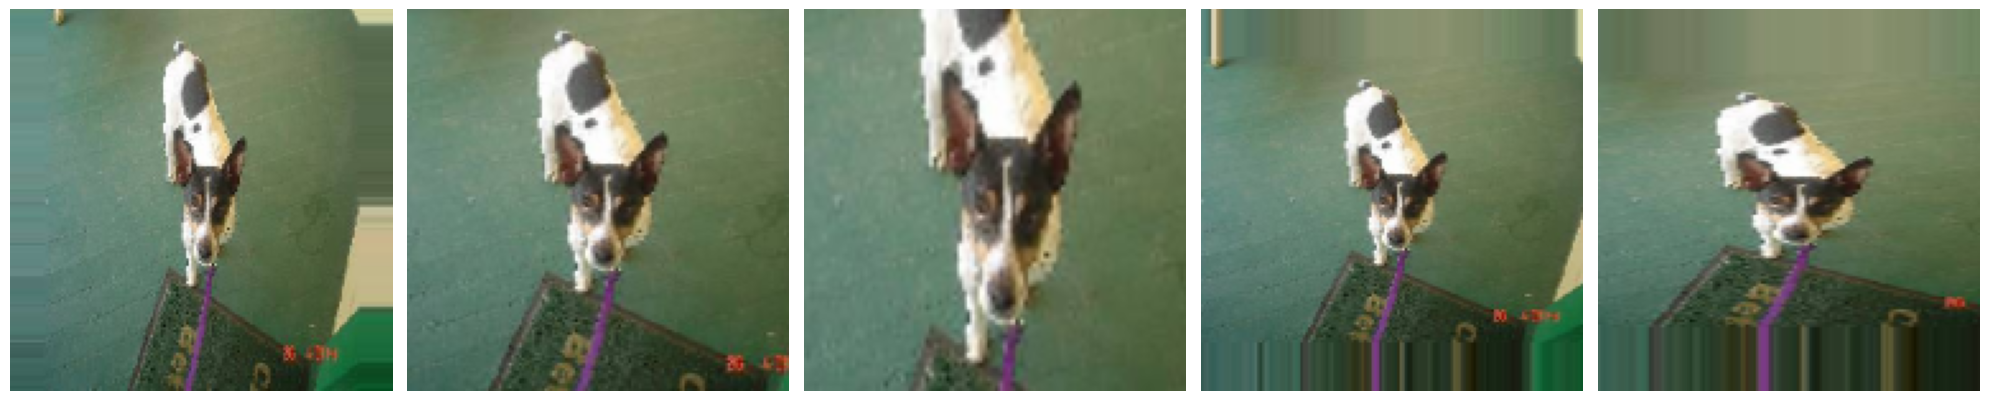

In [42]:
plotImages(augmented_images)

### Defining a couple of transformations

We will now apply a few transformations and prepare an image generator.

In [43]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [44]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


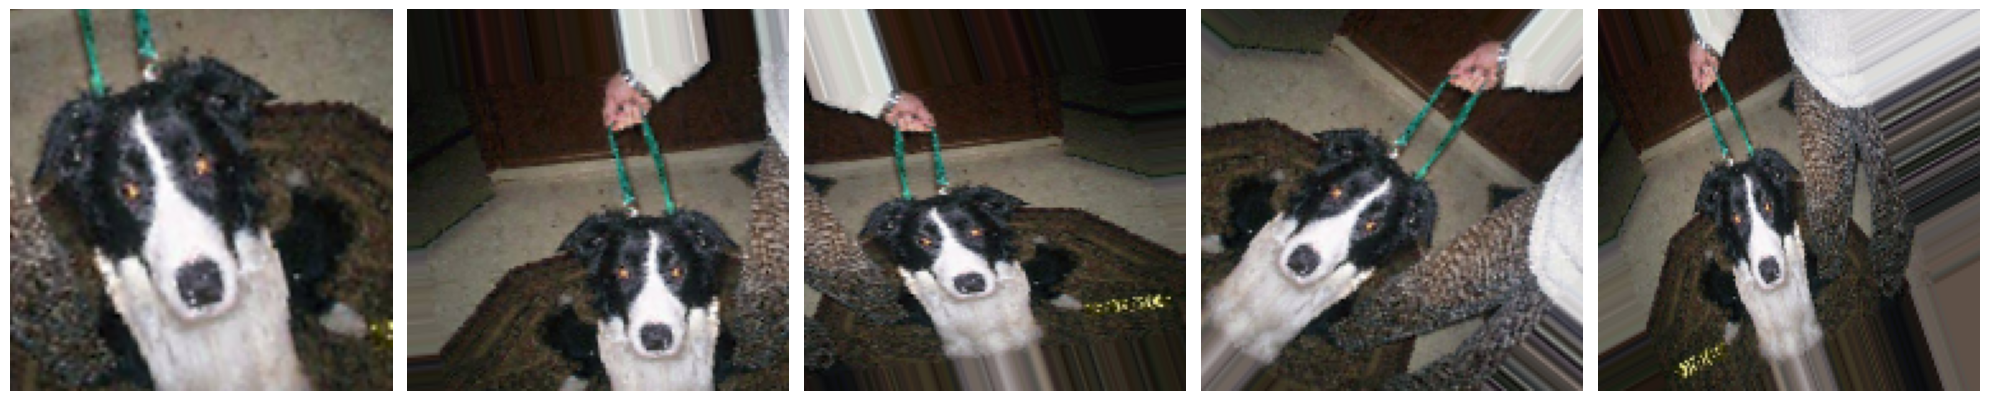

In [45]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating validation generator

Basically, we don't want to add any transformations over the validation images, so the validation image generator will practically remain as it was in the previous example.

In [46]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [47]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## Dropout

Dropout regularization is a regularization technique which can improve the stability of the optimization or training of the neural network. During training, we will also use the `Dropout` regularization technique. Let us remind ourselves that in this way we exclude randomly selected neurons, enable a different flow of data through the network and reduce the dependencies of the output on the input.

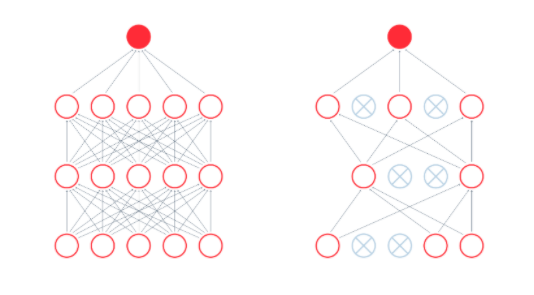

To apply this regularization technique, simply add the `Dropout` layer to the network. Its parameter is the probability of switching off individual neurons.

More precisely, dropout is defined over the layer by setting a parameter between 0 and 1. If we set the dropout to 0.1, during training, $10%$ of units will be randomly selected in that layer to be the kill output. What we mean by 'kill' is to set the neuron to $0$. As neural net is a collection multiplicative operations, then those $0$ neuron won't propagate anything to the rest of the network.

It's easy to remember things when the network has a lot of parameters (overfit), but it's hard to remember things when effectively the network only has so many parameters to work with. Hence, the network must learn to generalize more to get the same performance as remembering things.

So, that's why Dropout will increase the test time performance: it improves generalization and reduce the risk of overfitting.

The correction layer, the `Flatten` layer, is used to transform value matrices into vectors and is usually used as a preparation for the transition from the convolutional part to the further dense part of the network. Thus, flattening a tensor means to remove all of the dimensions except for one.

More information about dropout can be found [here](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/).

## Defining a new network which has a Dropout

We will set the dropout after the convolution and pooling pairs with a value of 0.2.

In [48]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

### Compiling the model

In [49]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 75, 75, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 64)       

### Training the model

After the changes we introduced, it is finally time to retrain the model!

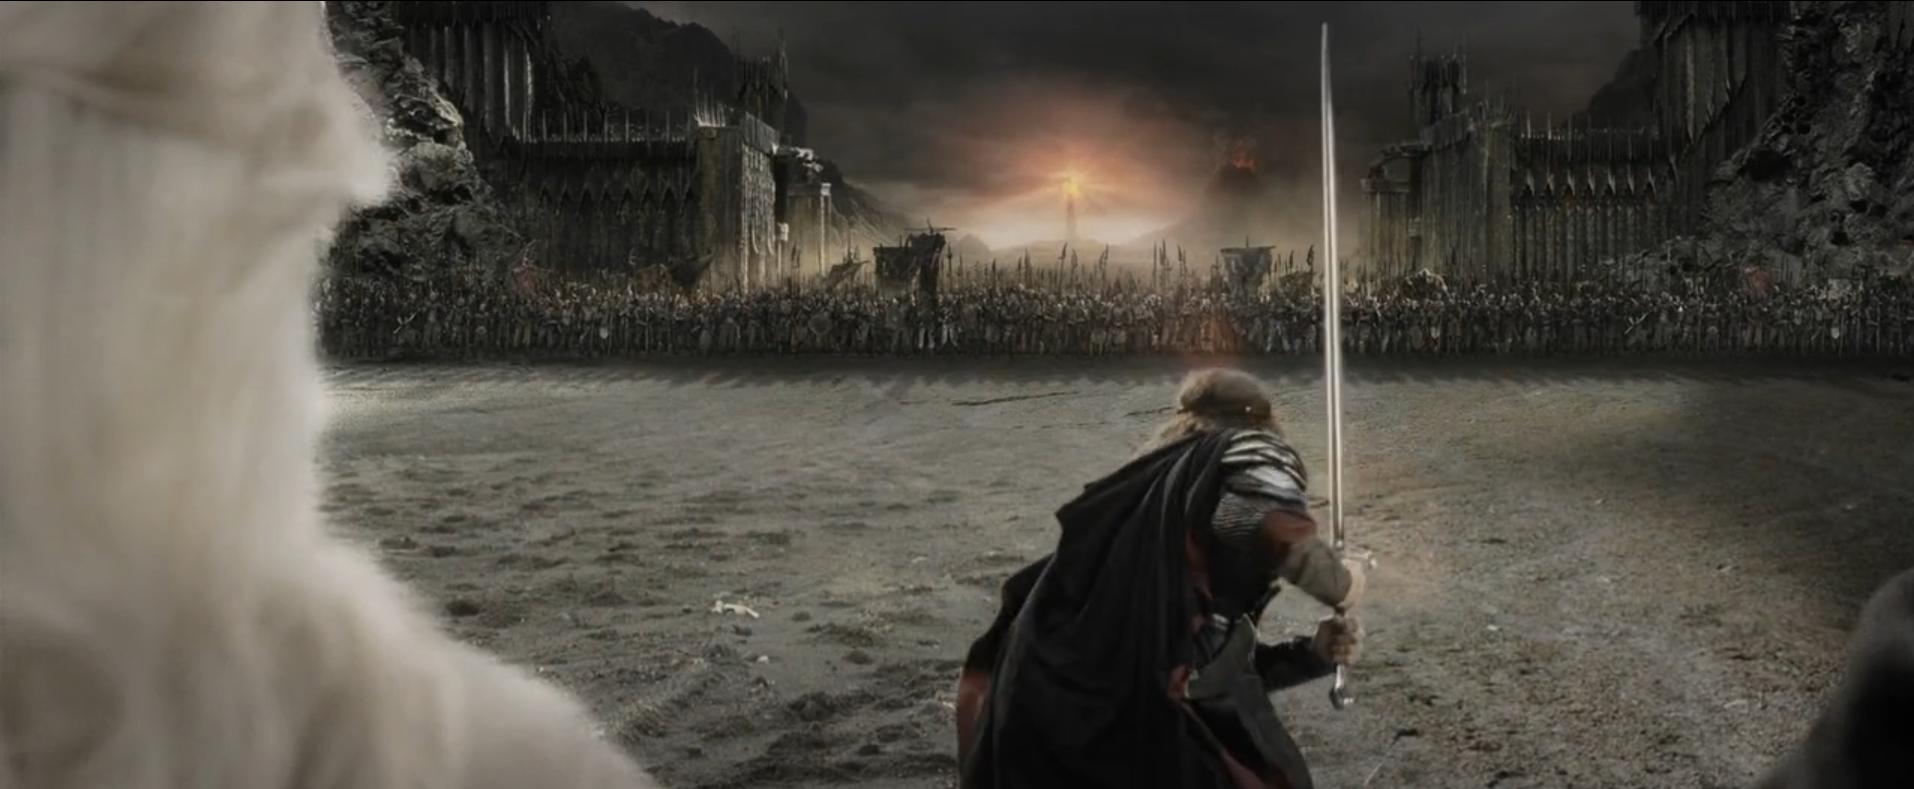

In [50]:
history = model_new.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/20
15/15 [==============================] - 29s 2s/step - loss: 1.0671 - accuracy: 0.4861 - val_loss: 0.6937 - val_accuracy: 0.5011
Epoch 2/20
15/15 [==============================] - 24s 2s/step - loss: 0.6925 - accuracy: 0.5011 - val_loss: 0.6912 - val_accuracy: 0.5100
Epoch 3/20
15/15 [==============================] - 24s 2s/step - loss: 0.6902 - accuracy: 0.5315 - val_loss: 0.6836 - val_accuracy: 0.5893
Epoch 4/20
15/15 [==============================] - 24s 2s/step - loss: 0.6855 - accuracy: 0.5524 - val_loss: 0.6769 - val_accuracy: 0.5926
Epoch 5/20
15/15 [==============================] - 23s 2s/step - loss: 0.6744 - accuracy: 0.5759 - val_loss: 0.6445 - val_accuracy: 0.6283
Epoch 6/20
15/15 [==============================] - 23s 2s/step - loss: 0.6576 - accuracy: 0.5924 - val_loss: 0.6501 - val_accuracy: 0.6406
Epoch 7/20
15/15 [==============================] - 23s 2s/step - loss: 0.6519 - accuracy: 0.6197 - val_loss: 0.6391 - val_accuracy: 0.5926
Epoch 8/20
15/15 [==

### Model evaluation

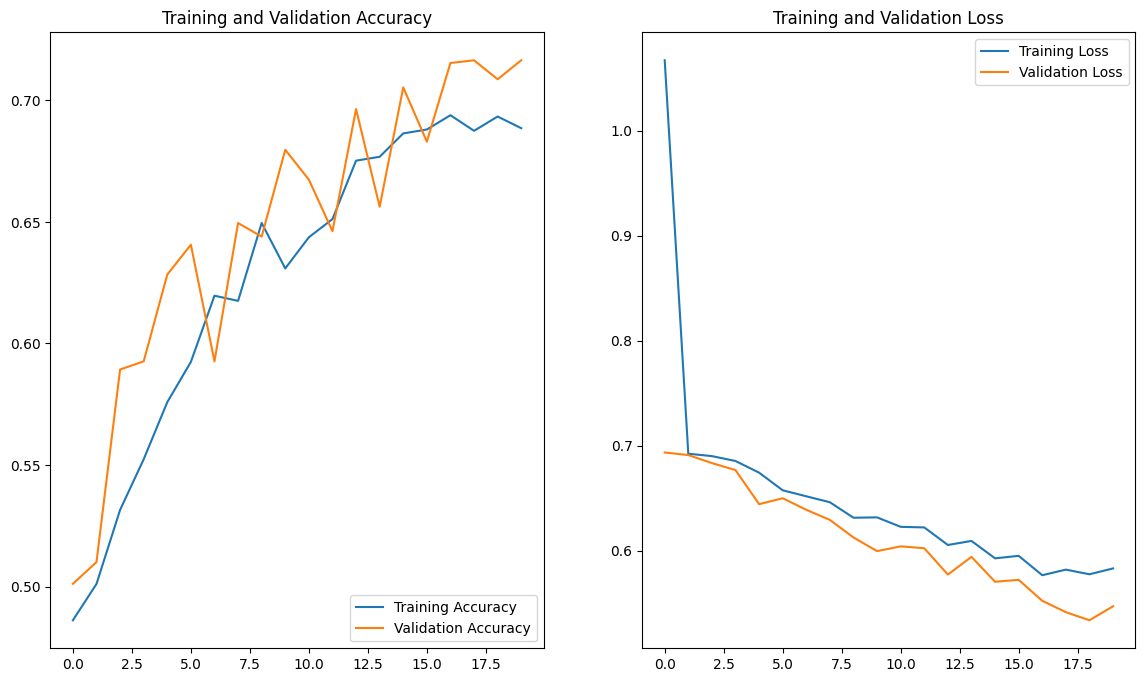

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can notice that the model is now in a much better situation compared to the last attempt! It makes sense to extend the number of epochs, use `EarlyStopping` and see how much the model is able to learn.

<div class='alert alert-info'>
    For further reading:
    <a href='https://cs231n.github.io/convolutional-networks/'> CNN for visual recognition </a>
</div>